<h1> Dstl Satellite Imagery Feature Detection </h1>

## 1. Business Problem

## 1.1 Description

Dstl's Satellite Imagery competition, which ran on Kaggle from December 2016 to March 2017, challenged Kagglers to identify and label significant features like waterways, buildings, and vehicles from multi-spectral overhead imagery. Automating feature labeling will not only help Dstl make smart decisions more quickly around the defense and security of the UK, but also bring innovation to computer vision methodologies applied to satellite imagery.

<p style='font-size:18px'><b> Problem Statemtent </b></p>

In this competition, Dstl provides you with 1km x 1km satellite images in both 3-band and 16-band formats. Your goal is to detect and classify the types of objects found in these regions.

3- and 16-bands images

There are two types of imagery spectral content provided in this competition. The 3-band images are the traditional RGB natural color images. The 16-band images contain spectral information by capturing wider wavelength channels. This multi-band imagery is taken from the multispectral (400 – 1040nm) and short-wave infrared (SWIR) (1195-2365nm) range.

<p style='font-size:18px'><b> Source:  </b> https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/overview </p>

<h1> 2. Deep Learning problem </h1>
<h2> 2.1 Data 
<h3> 2.1.1 Data Overview </h3>

Refer: https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/data
<br>All of the data is in 5 files: <br/>

1. __train_wkt.csv__ - the WKT format of all the training labels.
 - ImageId - ID of the image
 - ClassType - type of objects (1-10)
 - MultipolygonWKT - the labeled area, which is multipolygon geometry represented in WKT format.
 
 
2. __three_band.zip__ - the complete dataset of 3-band satellite images. The three bands are in the images with file name = {ImageId}.tif. MD5 = 7cf7bf17ba3fa3198a401ef67f4ef9b4


3. __sixteen_band.zip__ - the complete dataset of 16-band satellite images. The 16 bands are distributed in the images with file name = {ImageId}_{A/M/P}.tif. MD5 = e2949f19a0d1102827fce35117c5f08a


4. __grid_sizes.csv__ - the sizes of grids for all the images
   - ImageId - ID of the image
   - Xmax - maximum X coordinate for the image
   - Ymin - minimum Y coordinate for the image


5. __train_geojson.zip__ - the geojson format of all the training labels(essentially these are the same information as train_wkt.csv)  


> All imagery credit to: Satellite Imagery © DigitalGlobe, Inc.

Imagery details
- Sensor : WorldView 3
- Wavebands :
   - Panchromatic: 450-800 nm
   - 8 Multispectral: (red, red edge, coastal, blue, green, yellow, near-IR1 and near-IR2) 400 nm - 1040 nm
   - 8 SWIR: 1195 nm - 2365 nm
- Sensor Resolution (GSD) at Nadir :
    - Panchromatic: 0.31m 
    - Multispectral: 1.24 m
    - SWIR: Delivered at 7.5m
- Dynamic Range
    Panchromatic and multispectral : 11-bits per pixel
    SWIR : 14-bits per pixel



<h3>2.1.2 Object types</h3>

In a satellite image, you will find lots of different objects like roads, buildings, vehicles, farms, trees, water ways, etc. Dstl has labeled 10 different classes:

1. __Buildings__ - large building, residential, non-residential, fuel storage facility, fortified building
2. __Misc. Manmade structures__
3. __Road__
4. __Track__ - poor/dirt/cart track, footpath/trail
5. __Trees__ - woodland, hedgerows, groups of trees, standalone trees
6. __Crops__ - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops
7. __Waterway__ 
8. __Standing water__
9. __Vehicle Large__ - large vehicle (e.g. lorry, truck,bus), logistics vehicle
10. __Vehicle Small__ - small vehicle (car, van), motorbike

Every object class is described in the form of Polygons and MultiPolygons, which are simply a list of polygons. We provide two different formats for these shapes: __[GeoJson](https://geojson.org/)__ and __[WKT](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry)__. These are both open source formats for geo-spatial shapes. 

<h2>2.2 Mapping the real world problem to a Deep Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<pre>
Goal is to detect and classify the types of objects found in these regions.
Object detection problem like roads, building, vehicles, farms, trees, water way etc.
</pre>

<h3> 2.2.2 Performance Metric </h3>

__Average Jaccard Index__ between the predicted multipolygons and the actual multipolygons.
- The __[Jaccard Index](https://en.wikipedia.org/wiki/Jaccard_index)__ for two regions A and B, also known as the "intersection over union", is defined as:

$ Jaccard = {\frac{TP}{TP+FP+FN} }= {{|A \cap B|}\over{|A \cup B|}} = {{|A \cap B|}\over{|A| + |B| - |A \cap B|}} $

In [1]:
## Import library
import pandas as pd
import numpy as np
from shapely.wkt import loads           # https://pypi.org/project/Shapely/
from matplotlib.patches import Polygon, Patch  # plot Polygon using Matplotlib:https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.Polygon.html
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_similarity_score
from collections import defaultdict
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity

In [0]:
!mkdir .kaggle

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [9]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
!kaggle competitions download -c dstl-satellite-imagery-feature-detection -p /content

100% 12.9G/12.9G [01:52<00:00, 219MB/s]
100% 12.9G/12.9G [01:52<00:00, 123MB/s]
  0% 0.00/14.9k [00:00<?, ?B/s]
100% 14.9k/14.9k [00:00<00:00, 15.0MB/s]
 81% 9.00M/11.1M [00:00<00:00, 76.7MB/s]
100% 11.1M/11.1M [00:00<00:00, 71.0MB/s]
 56% 8.00M/14.2M [00:00<00:00, 81.6MB/s]
100% 14.2M/14.2M [00:00<00:00, 90.9MB/s]
100% 7.30G/7.30G [01:08<00:00, 189MB/s]
100% 7.30G/7.30G [01:08<00:00, 114MB/s]
  0% 0.00/2.17k [00:00<?, ?B/s]
100% 2.17k/2.17k [00:00<00:00, 2.23MB/s]


<h1> 3. Exploratory Data Analysis </h1>

## 3.1 Reading WKT and plotting with Pyplot

In [2]:
tr_wkt = pd.read_csv('train_wkt_v4.csv')  # Well-known text Multipolygon
tr_wkt.head()

ImageId  ClassType                                    MultipolygonWKT
0  6040_2_2          1                                 MULTIPOLYGON EMPTY
1  6040_2_2          2                                 MULTIPOLYGON EMPTY
2  6040_2_2          3                                 MULTIPOLYGON EMPTY
3  6040_2_2          4  MULTIPOLYGON (((0.003025 -0.007879000000000001...
4  6040_2_2          5  MULTIPOLYGON (((0.005311 -0.009044999999999999...

- Let's look at all available images and see how many objects of which type are there, what is there areas and how these vary from image to image.

In [3]:
# number of images in available dataset?
tr_wkt.ImageId.unique()

array(['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3',
       '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1',
       '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2',
       '6110_3_1', '6010_4_4', '6170_2_4', '6170_4_1', '6170_0_4',
       '6060_2_3', '6070_2_3', '6010_1_2', '6040_4_4', '6100_2_2'],
      dtype=object)

In [4]:
# convert to shapely, get geometries and pivot
tr_wkt['polygons'] = tr_wkt.apply(lambda row: loads(row.MultipolygonWKT),axis=1)
tr_wkt['nPolygons'] = tr_wkt.apply(lambda row: len(row['polygons'].geoms),axis=1)

pvt = tr_wkt.pivot(index='ImageId', columns='ClassType', values='nPolygons')
pvt

ClassType    1     2   3   4     5   6   7   8   9    10
ImageId                                                 
6010_1_2      0    44   0  12  1733   0   0   0   0    0
6010_4_2      0     0   0   6  2262   0   0   0   0    0
6010_4_4      0     0   0   0  3860   0   0   0   0    0
6040_1_0      0     0   0   5  2446   0   0   0   0    0
6040_1_3      0     0   0   1  3982   2   0   0   0    0
6040_2_2      0     0   0   2  3879   0   0   0   0    0
6040_4_4      0     0   0   7  1901   0   0   0   0    0
6060_2_3     62   173   0   7  1613  86   0   0   0    1
6070_2_3    109    81   2   0    41   0  24   3   0   13
6090_2_0      0    11   0   3  2308   7   0  19   0    1
6100_1_3   2208  1581   1  13   823   3   0   4  11  129
6100_2_2    633   454   1  27   878  11   4   1  13  101
6100_2_3   1690  1226   2  24   574   0   0   2  14  126
6110_1_2   1584  1420   1  10   855  28   0  63   0   23
6110_3_1    581   706   1  19  1239  35   0   9   3   25
6110_4_0    437   502   2  11  1406  29   0  24   7   13
6120_2_0    573  1193   1   4  1542  67   0   0   6   11
6120_2_2   1962  3201   1  33  1452  20   0   6   9  548
6140_1_2   1607  1111   1   9   817  27   0  75   0   23
6140_3_1    565   563   1  19  1110  37   0   9   3   46
6150_2_3      0    47   0   4  2060  68   0   0   0    0
6160_2_1      0     0   0   8  2432   0   0   0   0    0
6170_0_4      0     1   0   9  2774   0   0   8   0    0
6170_2_4      0     1   0   4  2115   2   0   1   0    0
6170_4_1      0     0   0   2  4245   0   0   0   0    0

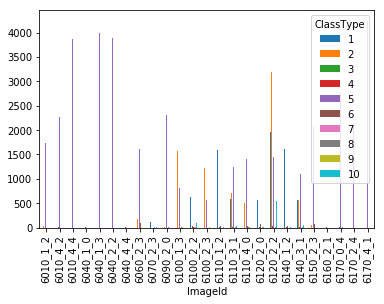

In [5]:
pvt.plot(kind='bar')

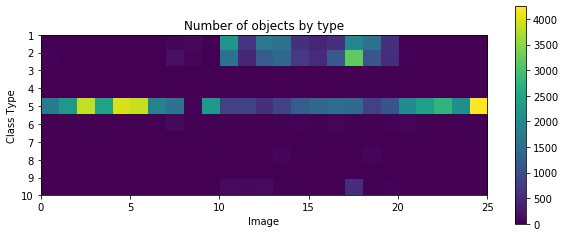

In [6]:
plt.subplots(figsize=(10, 4))
plt.imshow(pvt.T,extent=[0,25,10,1])
plt.yticks(np.arange(1, 11, 1.0))
plt.title('Number of objects by type')
plt.ylabel('Class Type')
plt.xlabel('Image')
plt.colorbar()
plt.show()

### Observation
1. Numbers-wise trees are leading by far, being the only major object type on some of the images. They are followed by buildings and other man structures, which are actually not present on every image, as well as vehicles.
2. Road, water way, vehicles are very few and only some of images.

## 3.2 Plot all Images

### 3.2.1 Plot polygons

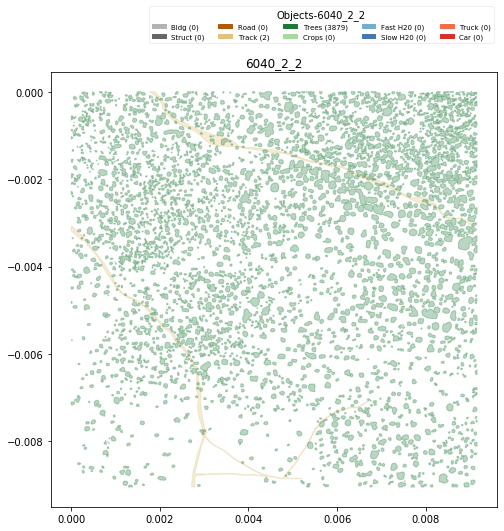

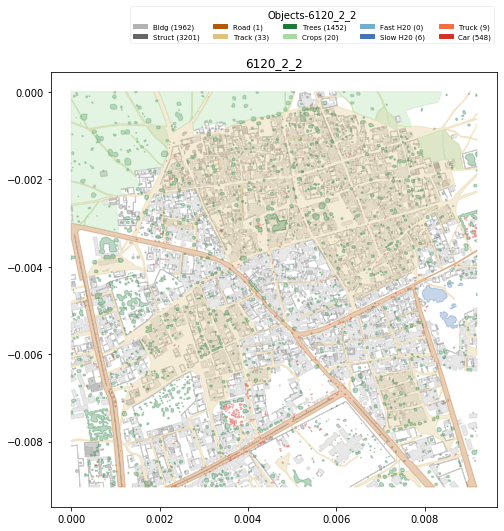

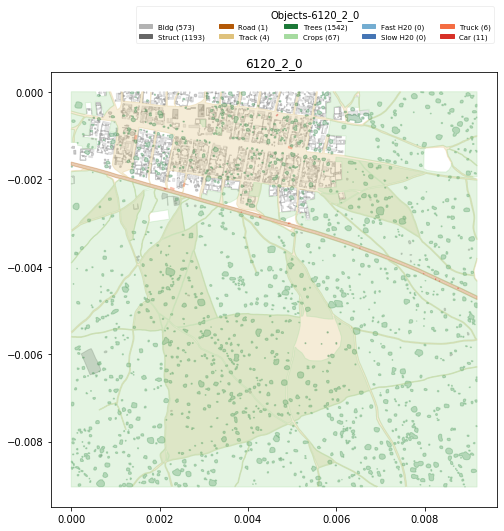

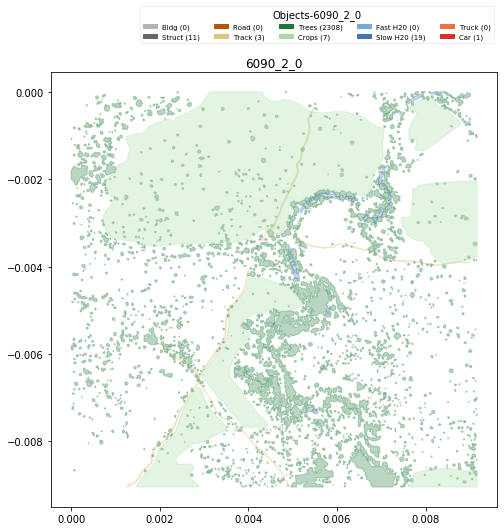

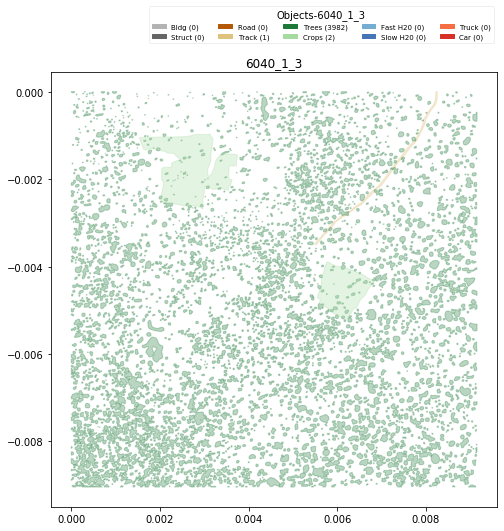

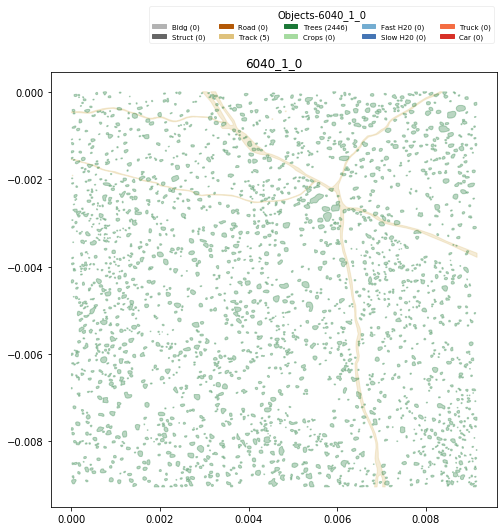

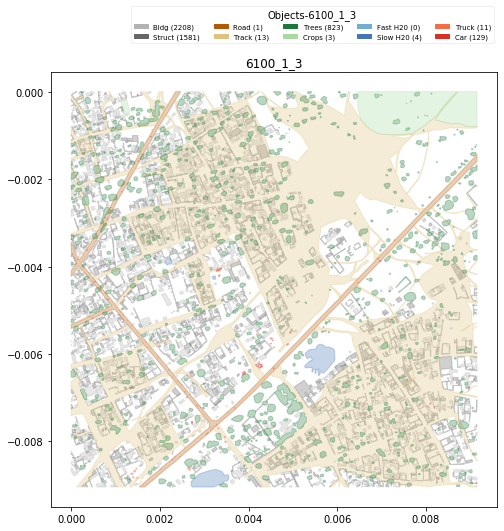

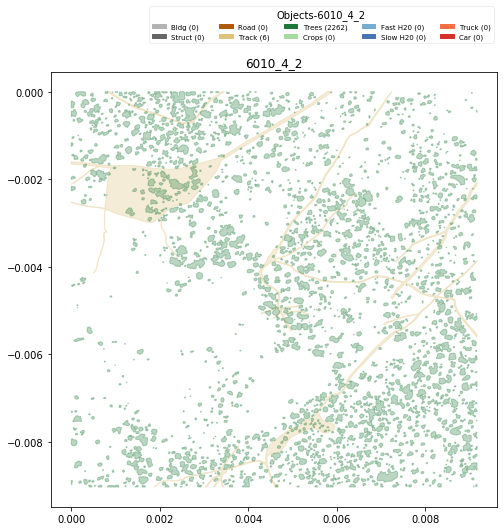

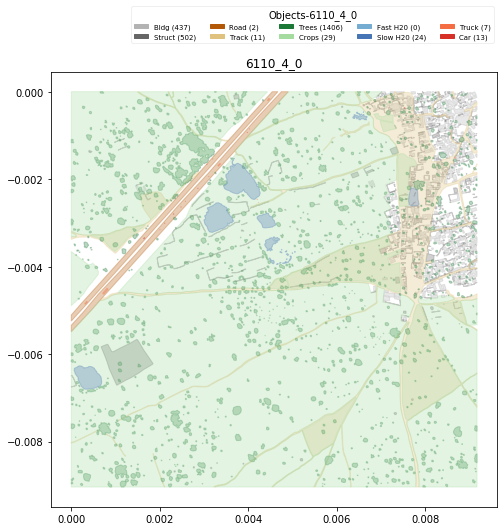

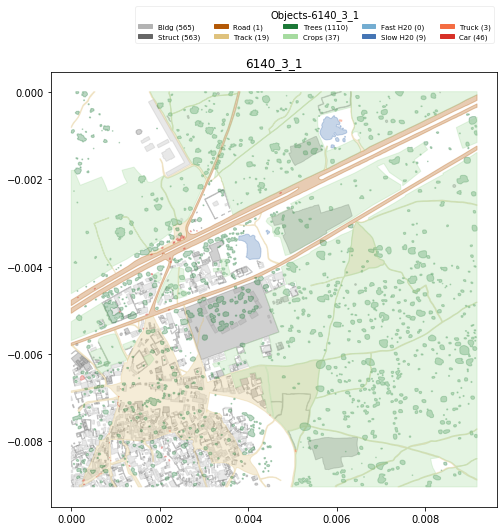

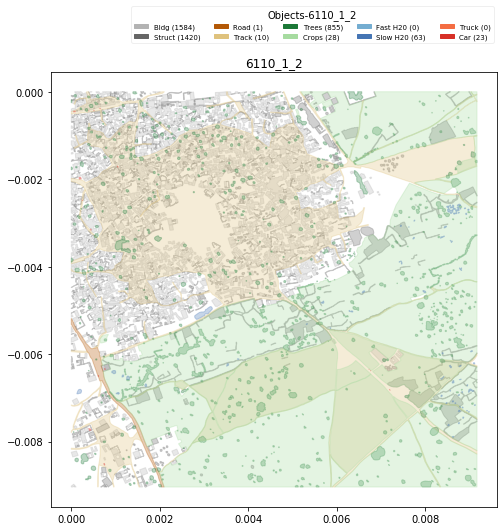

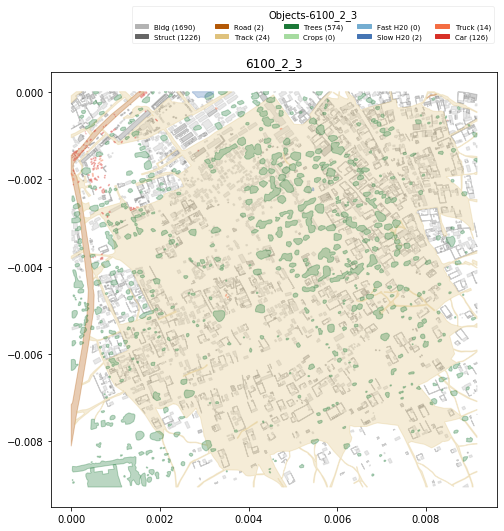

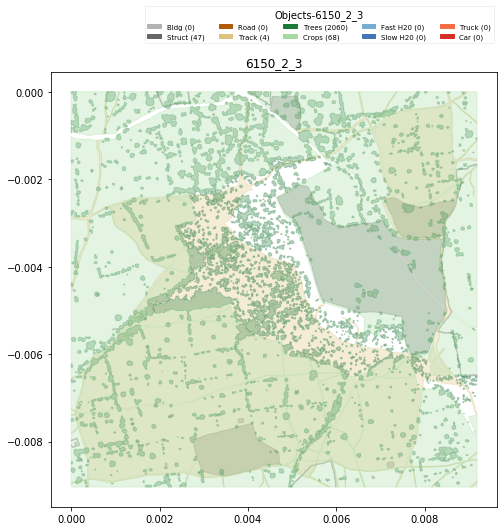

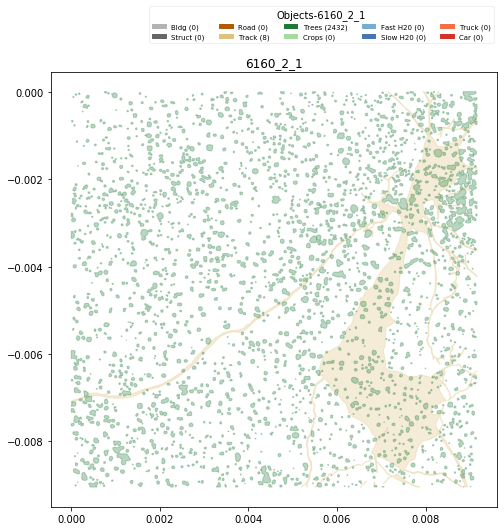

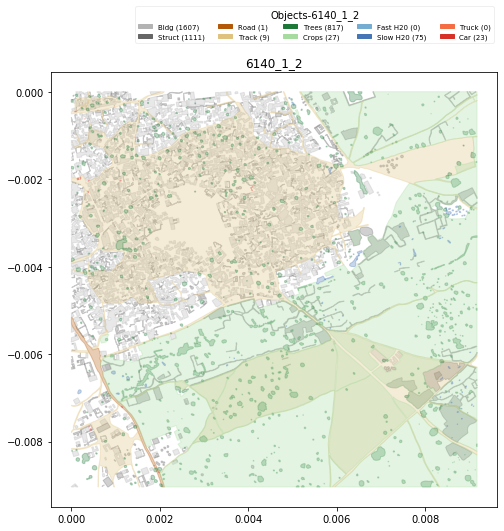

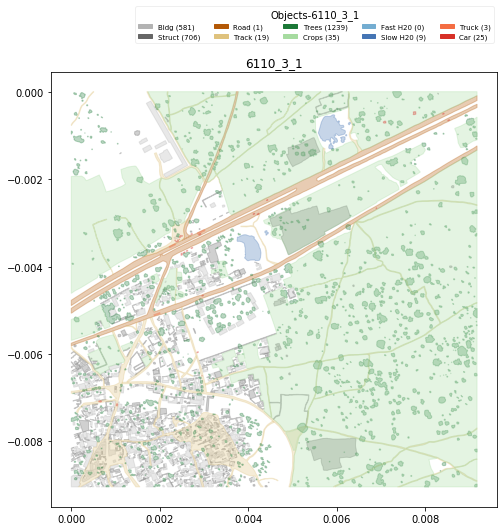

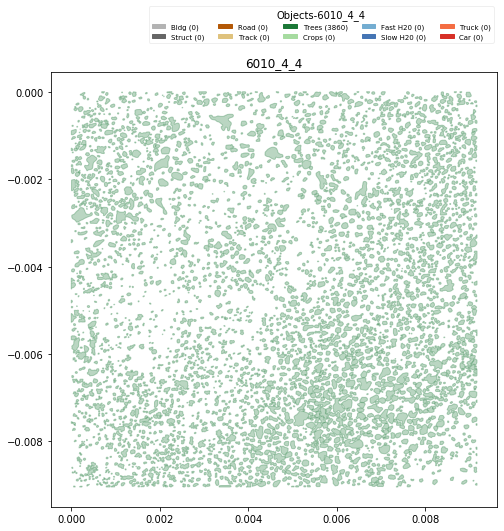

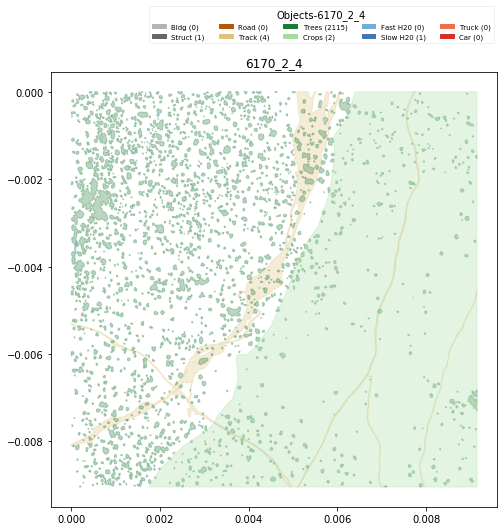

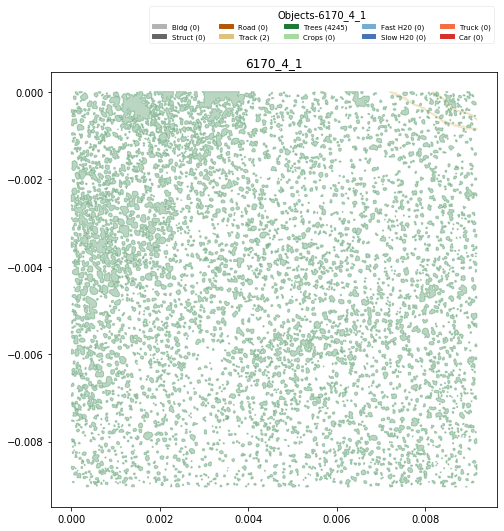

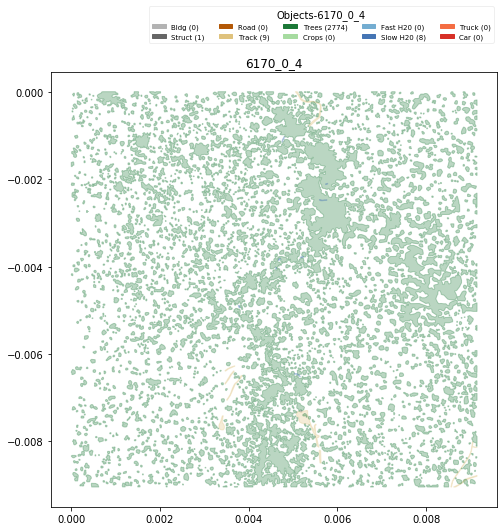

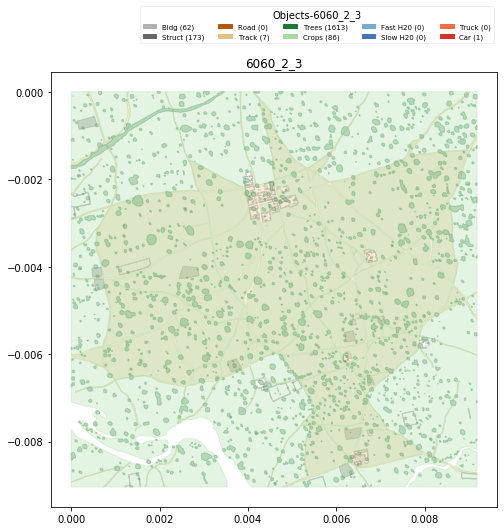

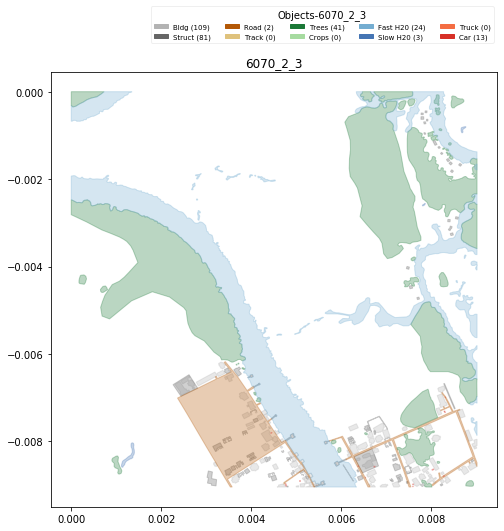

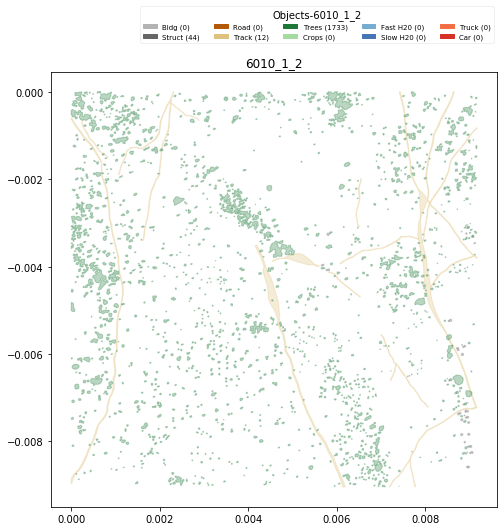

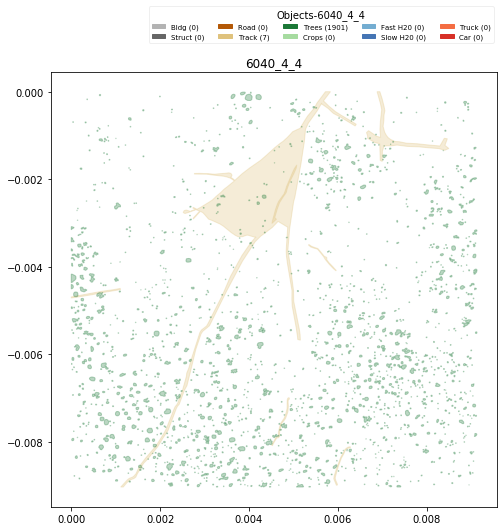

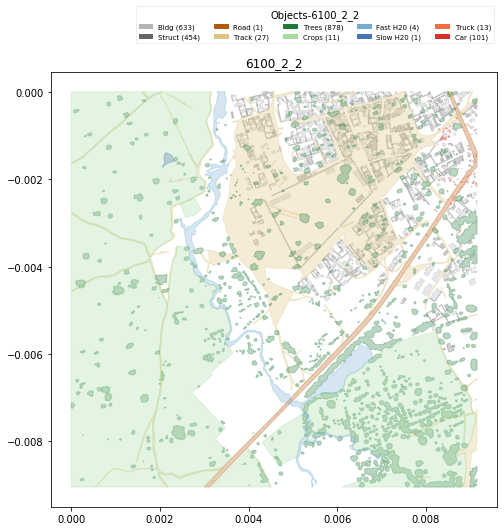

In [8]:
from matplotlib.patches import Polygon, Patch
COLORS = {1 : '0.7',2 : '0.4',3 : '#b35806',4 : '#dfc27d',5 : '#1b7837',6 : '#a6dba0',7 : '#74add1',8 : '#4575b4',9 : '#f46d43',10: '#d73027'}
CLASSES = {1 : 'Bldg',2 : 'Struct',3 : 'Road',4 : 'Track',5 : 'Trees',6 : 'Crops',7 : 'Fast H20',8 : 'Slow H20',9 : 'Truck',10 : 'Car'}
polygonsList = {}
for im in tr_wkt.ImageId.unique():
    image = tr_wkt[tr_wkt.ImageId == im]
    for cType in image.ClassType.unique():
        polygonsList[cType] = loads(image[image.ClassType == cType].MultipolygonWKT.values[0])
        
    # plot using matplotlib
    fig, ax = plt.subplots(figsize=(8,8))

    # plotting, color by class type
    legend_patches=[]
    for p in polygonsList:
        legend_patches.append(Patch(color=COLORS[p],label='{} ({})'.format(CLASSES[p], len(polygonsList[p]))))
        for polygon in polygonsList[p]:
            m_poly = Polygon(np.array(polygon.exterior), color=COLORS[p], alpha=0.3)
            ax.add_patch(m_poly)
            
    ax.relim()
    ax.autoscale_view()
    plt.title(im)
    plt.legend(handles=legend_patches,
                   # loc='upper center',
                   bbox_to_anchor=(0.9, 1),
                   bbox_transform=plt.gcf().transFigure,
                   ncol=5,
                   fontsize='x-small',
                   title='Objects-' + im,
                   # mode="expand",
                   framealpha=0.3)
    plt.show()        

### 3.2.2 Plot three_band Images

(3, 3349, 3391)

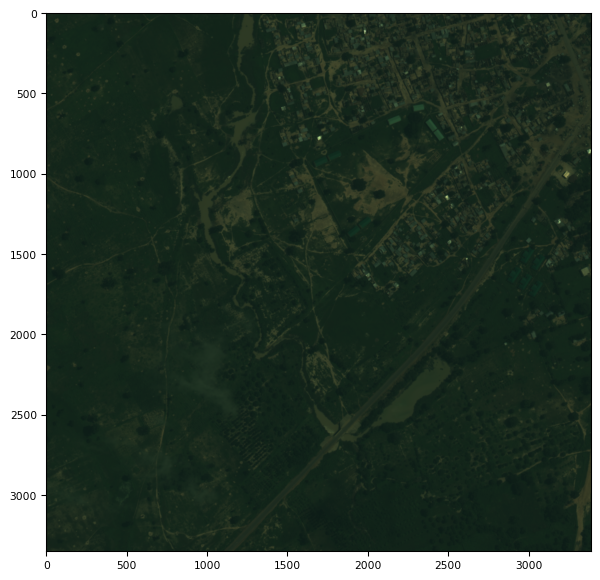

In [65]:
import tifffile as tiff
img_filename = 'three_band/6100_2_2.tif'
Image = tiff.imread(img_filename)
tiff.imshow(Image)
np.shape(Image)

### 3.2.3 Plot sixteen_band type: A Image

(8, 134, 136)

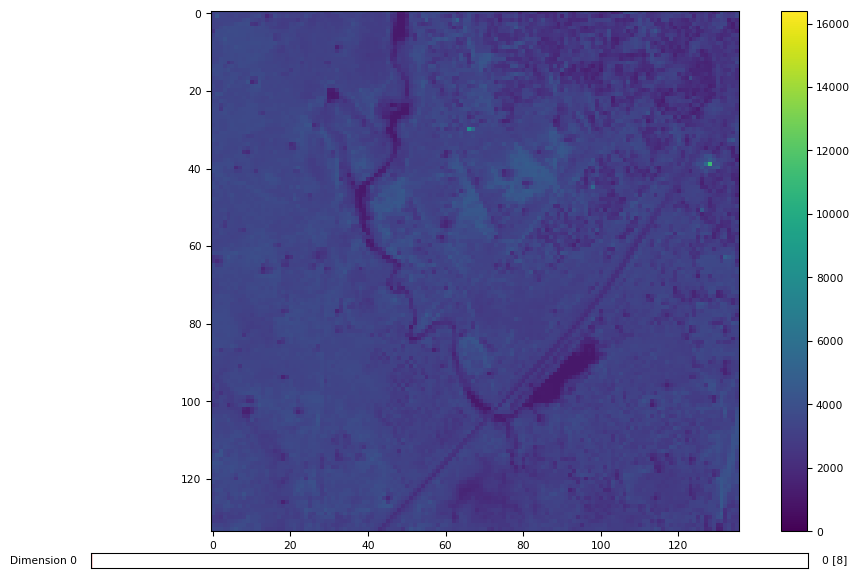

In [10]:
img_filename = 'sixteen_band/6100_2_2_A.tif'
Image = tiff.imread(img_filename)
tiff.imshow(Image)
np.shape(Image)

### 3.2.3 Plot sixteen_band type: M Image

(8, 837, 848)

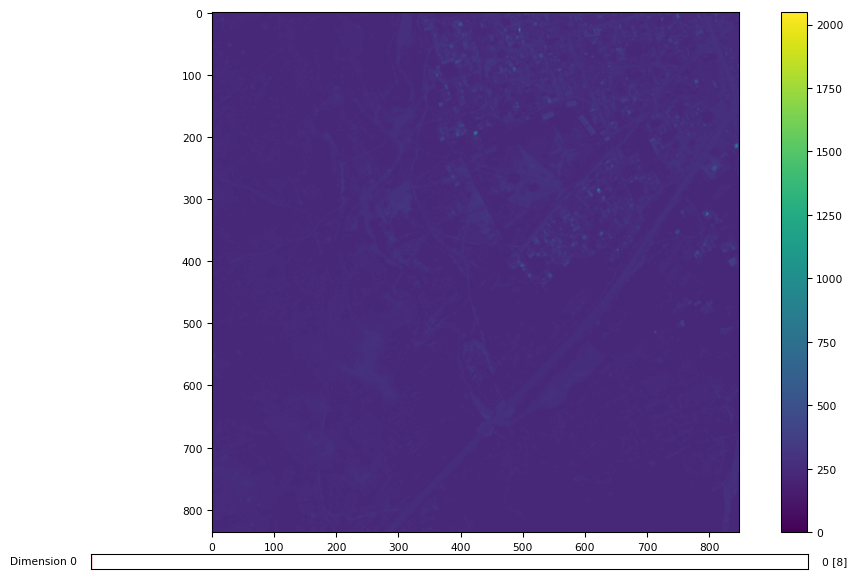

In [11]:
img_filename = 'sixteen_band/6100_2_2_M.tif'
Image = tiff.imread(img_filename)
tiff.imshow(Image)
np.shape(Image)

### 3.2.3 Plot sixteen_band type: P Image

(3348, 3391)

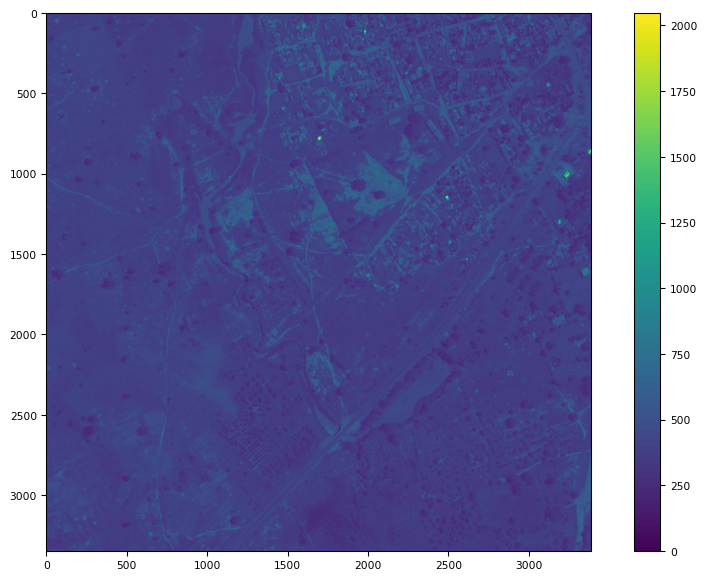

In [12]:
img_filename = 'sixteen_band/6100_2_2_P.tif'
Image = tiff.imread(img_filename)
tiff.imshow(Image)
np.shape(Image)

## Load grid_sizes file

In [12]:
grid_sizes = pd.read_csv('grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
grid_sizes.head()

ImageId      Xmax     Ymin
0  6120_2_4  0.009180 -0.00904
1  6120_2_3  0.009169 -0.00904
2  6120_2_2  0.009188 -0.00904
3  6120_2_1  0.009188 -0.00904
4  6120_2_0  0.009188 -0.00904

In [6]:
def convert_coordinates(coords, img_size, xy_coords):
    '''
    Convert all image coordinates given range
    '''
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymin = xy_coords              # Xmax - maximum X coordinate for the image
                                        # Ymin - minimum Y coordinate for the image
    Height, Weight = img_size            # image sizes
    W = 1.0 * Weight * Weight / (Weight + 1)
    H = 1.0 * Height * Height / (Height + 1)
    xf = W / Xmax
    yf = H / Ymin
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

In [7]:
def get_xmax_ymin(GS, imageId):
    '''
    Find maximum coordinates for x and minimun coordinates for y
    ''' 
    xmax, ymin = GS[GS.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)

For get_xmax_ymin function
- Using grid_size.csv file find maximum coordinates for x and minimun coordinates for y

In [8]:
def get_polygon_list(wkt_list, imageId, cType):
    '''
    Find polygon list for all images with there class label
    '''
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list[wkt_list.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = loads(multipoly_def.values[0])
    return polygonList

For get_polygon_list function
- For each ImageId find polygon list if MultipolygonWKT is not NULL.
- if Mulipolygon is NULL then return None value of polygon list 

In [9]:
def get_and_convert_contours(polygonList, img_size, xy_coods):
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = convert_coordinates(perim, img_size, xy_coods)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = convert_coordinates(interior, img_size, xy_coods)
            interior_list.append(interior_c)
    return perim_list, interior_list

For get_and_convert_contours
- return exterior and interior co-ordinates of polygons
- poly.exterior.coords gives exterior co-ordinates
- poly.interior.coords give interior co-ordinates
- https://shapely.readthedocs.io/en/stable/manual.html#polygons

In [10]:
import cv2
def plot_mask_from_contours(img_size, contours):
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list,1)    
    cv2.fillPoly(img_mask, interior_list,0)
    return img_mask

The function __fillPoly__ fills an area bounded by several polygonal contours. The function can fill complex areas, for example, areas with holes, contours with self-intersections (some of their parts), and so forth.
https://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html#fillpoly

In [13]:
def generate_mask_for_image_and_class(img_size, imageId, class_type, GS=grid_sizes, wkt_list=tr_wkt):
    '''
    Fill polygons exterior and interior points and return mask of images
    '''
    xy_coods = get_xmax_ymin(GS, imageId)
    polygon_list = get_polygon_list(wkt_list, imageId, class_type)
    contours = get_and_convert_contours(polygon_list, img_size, xy_coods)
    mask = plot_mask_from_contours(img_size, contours)
    return mask

### Read all type of image data

In [14]:
def all_image(image_id, dims=20, size=800):
    if dims==3:
        filename = "three_band/{}.tif".format(image_id)
        img = tiff.imread(filename)
        img = np.rollaxis(img, 0, 3)
        img = cv2.resize(img, (size, size))
        
    elif dims==8:
        filename = "sixteen_band/{}_M.tif".format(image_id)
        img = tiff.imread(filename)
        img = np.rollaxis(img, 0, 3)
        img = cv2.resize(img, (size, size))
        
    elif dims==20:
        # for type M 
        img_M = np.transpose(tiff.imread("sixteen_band/{}_M.tif".format(image_id)), (1,2,0))
        img_M = cv2.resize(img_M, (size, size))
        # for type A
        img_A = np.transpose(tiff.imread("sixteen_band/{}_A.tif".format(image_id)), (1,2,0))
        img_A = cv2.resize(img_A, (size, size))
        # for type P
        img_P = tiff.imread("sixteen_band/{}_P.tif".format(image_id))
        img_P = cv2.resize(img_P, (size, size))

        filename = "three_band/{}.tif".format(image_id)
        # for RGB 
        img_RGB = tiff.imread(filename)
        img_RGB = np.rollaxis(img_RGB, 0, 3)
        img_RGB = cv2.resize(img_RGB, (size, size))

        img = np.zeros((img_RGB.shape[0], img_RGB.shape[1], dims), "float32")
        img[..., 0:3] = img_RGB
        img[..., 3] = img_P
        img[..., 4:12] = img_M
        img[..., 12:21] = img_A
        
    return img

In [15]:
def stretch_n(img, lower_percent=5, higher_percent=95):    # https://www.kaggle.com/aamaia/rgb-using-m-bands-example
    out = np.zeros_like(img, dtype=np.float32)
    n = img.shape[2]
    for i in range(n):
        a = 0       # np.min(img)
        b = 1       # np.max(img)
        c = np.percentile(img[:, :, i], lower_percent)
        d = np.percentile(img[:, :, i], higher_percent)
        t = a + (img[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t
    return out.astype(np.float32)

### Metric for performance evaluation 

In [16]:
smooth = 1e-12
def jaccard_coef(y_true, y_pred):
    # # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

### Stick all images together 

In [17]:
N_Cls = 10 # total number of class
def stick_all_train():
    print("let's stick all imgs together")
    s = 800 # 800 is the size of the all images

    x = np.zeros((5 * s, 5 * s, 20))        # the array has the dimensions of 5 images wide and 5 images high. 20 Channels
    y = np.zeros((5 * s, 5 * s, N_Cls))

    ids = sorted(tr_wkt.ImageId.unique())
    print(len(ids))
    for i in range(5):
        for j in range(5):
            id = ids[5 * i + j]

            img = all_image(id)
            img = stretch_n(img)
            print(img.shape, id, np.amax(img), np.amin(img))
            x[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class((img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

    print(np.amax(y), np.amin(y))

    np.save('data/x_trn_%d' % N_Cls, x)
    np.save('data/y_trn_%d' % N_Cls, y)

In [18]:
def get_patches(img, msk, amt=10000, aug=True):
    is2 = int(1.0 * ISZ)
    xm, ym = img.shape[0] - is2, img.shape[1] - is2

    x, y = [], []

    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]      # threshold for all class which is the best for pixels
    for i in range(amt):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]        # generate random image
        ms = msk[xc:xc + is2, yc:yc + is2]        # generate random mask 

        for j in range(N_Cls):
            sm = np.sum(ms[:, :, j])
            if 1.0 * sm / is2 ** 2 > tr[j]:
                if aug:
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]

                x.append(im)
                y.append(ms)

    x, y = 2 * np.transpose(x, (0, 3, 1, 2)) - 1, np.transpose(y, (0, 3, 1, 2))
    print(x.shape, y.shape, np.amax(x), np.amin(x), np.amax(y), np.amin(y))
    return x, y

## Plot image after join all band of image

In [25]:
m = all_image('6100_1_2')
m.shape

(800, 800, 20)

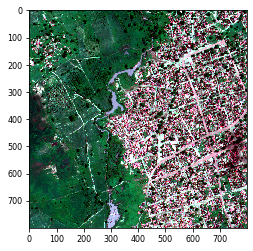

In [27]:
img = np.zeros((800,800,3))
img[:,:,0] = m[:,:,4] #red
img[:,:,1] = m[:,:,3] #green
img[:,:,2] = m[:,:,1] #blue
plt.imshow(stretch_n(img))

## Split train and validation data

In [19]:
def make_val():
    print("let's pick some samples for validation")
    img = np.load('data/x_trn_%d.npy' % N_Cls)
    msk = np.load('data/y_trn_%d.npy' % N_Cls)
    x, y = get_patches(img, msk, amt=1500)

    np.save('data/x_tmp_%d' % N_Cls, x)
    np.save('data/y_tmp_%d' % N_Cls, y)

In [29]:
import random
from keras.models import Model, load_model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
#K.set_image_dim_ordering('th')
K.set_image_data_format('channels_first')

## Create model for training 
- This type of network architecture was especially designed to effectively solve image segmentation problems. U-Net was the default choice for us and other competitors. If you would like more insights into architecture we suggest that you read the __[original paper](https://arxiv.org/abs/1505.04597)__. 

In [20]:
def get_unet():
    inputs = Input((20, ISZ, ISZ))
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding ='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding ='same')(conv5)
    
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=1)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(N_Cls, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model

In [31]:
model = get_unet()
model.summary()














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 160, 160) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 160, 160) 5792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 160, 160) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 80, 80)   0           conv2d_2[0][0]     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


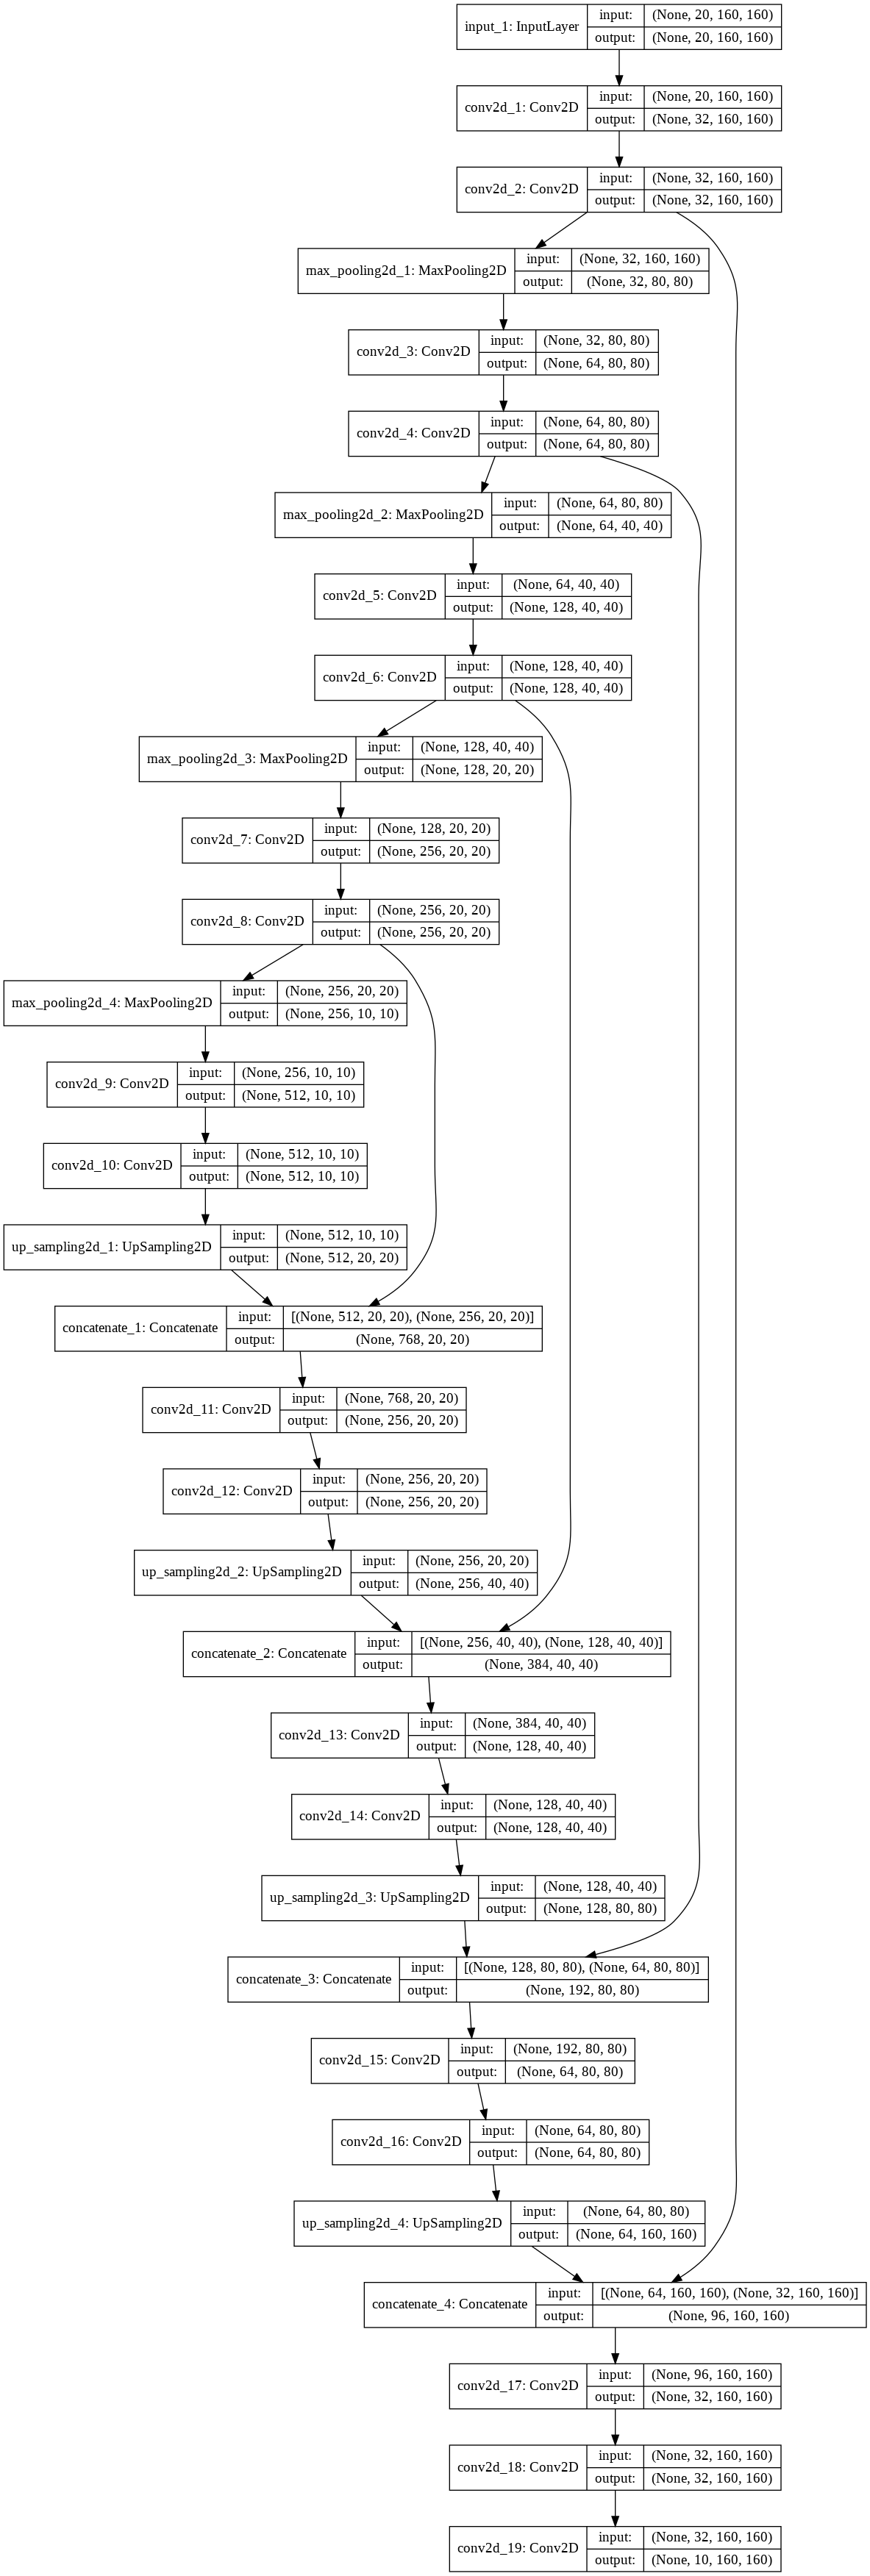

In [32]:
import keras
import pydot
from keras.utils import plot_model
import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

## Calculate jaccard Score for model

For every pixel P and every class X the model estimates the probability that that pixel belongs to that class. For the prediction, the script needs to determine what is the threshold above which P is considered to actually be of class X. This is done in calc_jacc, where it's determined using the validation set, i.e. the thresholds for each class are chosen such that the Jaccard index is the highest (on the validation set).

In [0]:
def calc_jacc(model):
    img = np.load('data/x_tmp_%d.npy' % N_Cls)
    msk = np.load('data/y_tmp_%d.npy' % N_Cls)

    prd = model.predict(img, batch_size=4)
    print(prd.shape, msk.shape)
    avg, trs = [], []

    for i in range(N_Cls):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])

        m, b_tr = 0, 0
        for j in range(10):
            tr = j / 10.0
            pred_binary_mask = t_prd > tr

            jk = jaccard_similarity_score(t_msk, pred_binary_mask)      # calculate jaccard similarity for predict mask and actual mask
            if jk > m:
                m = jk
                b_tr = tr
        print(i, m, b_tr)
        avg.append(m)
        trs.append(b_tr)

    score = sum(avg) / 10.0
    return score, trs

## Train model function and save weights

In [21]:
def train_net():
    print("start train net")
    x_val, y_val = np.load('data/x_tmp_%d.npy' % N_Cls), np.load('data/y_tmp_%d.npy' % N_Cls)    # load validate data
    img = np.load('data/x_trn_%d.npy' % N_Cls)
    msk = np.load('data/y_trn_%d.npy' % N_Cls)

    x_trn, y_trn = get_patches(img, msk)    # generate train data

    model = get_unet()      # call model
  
    model_checkpoint = ModelCheckpoint('weights/unet_tmp.hdf5', monitor='loss', save_best_only=True)   # moniter loss function
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir='./logs')          #tensorflow histogram for ploting
    for i in range(2):
        model.fit(x_trn, y_trn, batch_size=64, nb_epoch=5, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint,tensorboard_callback], validation_data=(x_val, y_val))       # fit model
        del x_trn
        del y_trn
        x_trn, y_trn = get_patches(img, msk)
        score, trs = calc_jacc(model)
        print('val jk', score)
        model.save_weights('weights/unet_10_jk%.4f' % score)       #save weights 

    return model

In [35]:
stick_all_train()

let's stick all imgs together
25
(800, 800, 20) 6010_1_2 1.0 0.0
(800, 800, 20) 6010_4_2 1.0 0.0
(800, 800, 20) 6010_4_4 1.0 0.0
(800, 800, 20) 6040_1_0 1.0 0.0
(800, 800, 20) 6040_1_3 1.0 0.0
(800, 800, 20) 6040_2_2 1.0 0.0
(800, 800, 20) 6040_4_4 1.0 0.0
(800, 800, 20) 6060_2_3 1.0 0.0
(800, 800, 20) 6070_2_3 1.0 0.0
(800, 800, 20) 6090_2_0 1.0 0.0
(800, 800, 20) 6100_1_3 1.0 0.0
(800, 800, 20) 6100_2_2 1.0 0.0
(800, 800, 20) 6100_2_3 1.0 0.0
(800, 800, 20) 6110_1_2 1.0 0.0
(800, 800, 20) 6110_3_1 1.0 0.0
(800, 800, 20) 6110_4_0 1.0 0.0
(800, 800, 20) 6120_2_0 1.0 0.0
(800, 800, 20) 6120_2_2 1.0 0.0
(800, 800, 20) 6140_1_2 1.0 0.0
(800, 800, 20) 6140_3_1 1.0 0.0
(800, 800, 20) 6150_2_3 1.0 0.0
(800, 800, 20) 6160_2_1 1.0 0.0
(800, 800, 20) 6170_0_4 1.0 0.0
(800, 800, 20) 6170_2_4 1.0 0.0
(800, 800, 20) 6170_4_1 1.0 0.0
1.0 0.0


In [36]:
make_val()

let's pick some samples for validation
(499, 20, 160, 160) (499, 10, 160, 160) 1.0 -1.0 1.0 0.0


In [0]:
import warnings
warnings.filterwarnings("default", category=DeprecationWarning)

In [38]:
model = train_net()

start train net
(1852, 20, 160, 160) (1852, 10, 160, 160) 1.0 -1.0 1.0 0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  




Train on 1852 samples, validate on 499 samples
Epoch 1/5
1852/1852 [==============================] - 35s 19ms/step - loss: 0.3420 - jaccard_coef: 0.0520 - jaccard_coef_int: 0.0341 - acc: 0.8674 - val_loss: 0.2014 - val_jaccard_coef: 0.0538 - val_jaccard_coef_int: 0.0523 - val_acc: 0.9434
Epoch 2/5
1852/1852 [==============================] - 23s 12ms/step - loss: 0.1704 - jaccard_coef: 0.0713 - jaccard_coef_int: 0.0635 - acc: 0.9438 - val_loss: 0.1503 - val_jaccard_coef: 0.0930 - val_jaccard_coef_int: 0.0899 - val_acc: 0.9483
Epoch 3/5
1852/1852 [==============================] - 23s 12ms/step - loss: 0.1409 - jaccard_coef: 0.1020 - jaccard_coef_int: 0.0922 - acc: 0.9496 - val_loss: 0.1285 - val_jaccard_coef: 0.1139 - val_jaccard_coef_int: 0.1077 - val_acc: 0.9547
Epoch 4/5
1852/1852 [==============================] - 23s 12ms/step - loss: 0.1409 - jaccard_coef: 0.1098 - jaccard_coef_int: 0.1112 - acc: 0.9516 - val_loss: 0.1366 - val_jaccard_coef: 0.1152 - val_jaccard_coef_int: 0.12

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0 0.7138527054108217 0.9
1 0.6258517034068136 0.4
2 0.8295716432865732 0.6
3 0.4032314629258517 0.5
4 0.4505027820505269 0.3
5 0.8108785019833106 0.6
6 0.9515505907308374 0.4
7 0.9627254509018036 0.4
8 0.9861347695390782 0.3
9 0.9371242484969939 0.3
val jk 0.7671423858732611
Train on 1748 samples, validate on 499 samples
Epoch 1/5
1748/1748 [==============================] - 25s 14ms/step - loss: 0.1080 - jaccard_coef: 0.1540 - jaccard_coef_int: 0.1772 - acc: 0.9639 - val_loss: 0.1045 - val_jaccard_coef: 0.1685 - val_jaccard_coef_int: 0.1851 - val_acc: 0.9651
Epoch 2/5
1748/1748 [==============================] - 23s 13ms/step - loss: 0.0939 - jaccard_coef: 0.1927 - jaccard_coef_int: 0.2266 - acc: 0.9690 - val_loss: 0.0905 - val_jaccard_coef: 0.2266 - val_jaccard_coef_int: 0.2524 - val_acc: 0.9699
Epoch 3/5
1748/1748 [==============================] - 23s 13ms/step - loss: 0.0908 - jaccard_coef: 0.2027 - jaccard_coef_int: 0.2349 - acc: 0.9702 - val_loss: 0.0872 - val_jaccard_coef: 0.24

In [60]:
# call calc_jacc for calculate score
score, trs = calc_jacc(model)

(499, 10, 160, 160) (499, 10, 160, 160)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0 0.789330389066862 0.5
1 0.6258517034068136 0.4
2 0.8453828119631547 0.5
3 0.4032314629258517 0.4
4 0.49769304980270956 0.4
5 0.913459099704906 0.7
6 0.9745200466638567 0.3
7 0.9654768029599091 0.6
8 0.9861347695390782 0.3
9 0.9371242484969939 0.3


# Prediction for test data

## Create Mask for polygons

In [22]:
def mask_for_polygons(polygons, im_size):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

## Mask to polygon for submation 

In [23]:
def mask_to_polygons(mask, epsilon=1, min_area=10):
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    contours, hierarchy = cv2.findContours(((mask == 1) * 255).astype(np.uint8),cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True) for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

In [24]:
def predict_id(id, model, trs):
    img = all_image(id)
    x = stretch_n(img)

    cnv = np.zeros((960, 960, 8)).astype(np.float32)
    prd = np.zeros((N_Cls, 960, 960)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x

    for i in range(0, 6):
        line = []
        for j in range(0, 6):
            line.append(cnv[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])

        x = 2 * np.transpose(line, (0, 3, 1, 2)) - 1
        tmp = model.predict(x, batch_size=4)
        for j in range(tmp.shape[0]):
            prd[:, i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ] = tmp[j]

    for i in range(N_Cls):
        prd[i] = prd[i] > trs[i]

    return prd[:, :img.shape[0], :img.shape[1]]

In [25]:
def predict_test(model, trs):
    print("predict test")
    for i, id in enumerate(sorted(set(submission['ImageId'].tolist()))):
        msk = predict_id(id, model, trs)
        np.save('msk/10_%s' % id, msk)
        if i % 100 == 0:
            print(i, id)

In [57]:
submission = pd.read_csv('sample_submission.csv')
submission.head()

ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
1  6120_2_4          2  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
2  6120_2_4          3  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
3  6120_2_4          4  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
4  6120_2_4          5  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...

In [47]:
predict_test(model, trs)

predict test
0 6010_0_0
100 6050_1_0
200 6090_1_1
300 6130_2_4
400 6170_4_0


## Scale image for submission

In [26]:
def get_scalers(im_size, x_max, y_min):
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = 1.0 * w * (w / (w + 1))
    h_ = 1.0 * h * (h / (h + 1))
    return w_ / x_max, h_ / y_min

## Make submassion on kaggle

In [27]:
def make_submit():
    """
    Creates the final submission by loading all raw predictions, creating 0-1 masks by thresholding them and
    creating Multipolygons from these masks.
    """
    print("make submission file")
    for idx, row in submission.iterrows():
        id = row[0]
        kls = row[1] - 1
        # Get the prediction from the respective class model and the best performing iteration of it
        msk = np.load('msk/10_%s.npy' % id)[kls]
        # msk = msk >= trs[kls]
        # Create correctly sizes polygons for the submission file
        pred_polygons = mask_to_polygons(msk)
        x_max = grid_sizes.loc[grid_sizes['ImageId'] == id, 'Xmax'].as_matrix()[0]
        y_min = grid_sizes.loc[grid_sizes['ImageId'] == id, 'Ymin'].as_matrix()[0]

        x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

        scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,
                                                      origin=(0, 0, 0))

        submission.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
        if submission.iloc[idx, 2]=="GEOMETRYCOLLECTION EMPTY":
            submission.iloc[idx, 2] = "MULTIPOLYGON EMPTY"
        if idx % 100 == 0:
            print(idx)
    print(submission.head())
    submission.to_csv('subm/1.csv', index=False)

In [58]:
make_submit()

make submission file
0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  MULTIPOLYGON (((0.0091340282812500 -0.00295298...
1  6120_2_4          2  MULTIPOLYGON (((0.0061697775937500 -0.00776148...
2  6120_2_4          3  MULTIPOLYGON (((0.0078012644062500 -0.00173106...
3  6120_2_4          4  MULTIPOLYGON (((0.0031136121562500 -0.00337160...
4  6120_2_4          5  MULTIPOLYGON (((0.0091799856562500 -0.00624539...


In [59]:
submission.tail()

ImageId  ClassType                                    MultipolygonWKT
4285  6130_1_0          6  MULTIPOLYGON (((0.0000344980687500 -0.00001131...
4286  6130_1_0          7                                 MULTIPOLYGON EMPTY
4287  6130_1_0          8                                 MULTIPOLYGON EMPTY
4288  6130_1_0          9                                 MULTIPOLYGON EMPTY
4289  6130_1_0         10                                 MULTIPOLYGON EMPTY

## Check prediction

In [0]:
def check_predict(id='6120_2_2'):
    model = get_unet()
    model.load_weights('weights/unet_10_jk0.7938')

    msk = predict_id(id, model, trs)
    img = all_image(id)
    img = stretch_n(img)
    plt.figure()
    #ax1 = plt.subplot(131)
    plt.title('image ID:6120_2_3')
    plt.imshow(img[:, :, 5])
    plt.show()
    #ax2 = plt.subplot(132)
    plt.title('predict bldg pixels')
    plt.imshow(msk[0], cmap=plt.get_cmap('gray'))
    plt.show() 
    #ax3 = plt.subplot(133)
    plt.title('predict bldg polygones')
    plt.imshow(mask_for_polygons(mask_to_polygons(msk[0], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))

    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


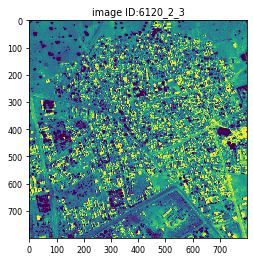

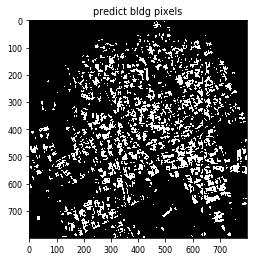

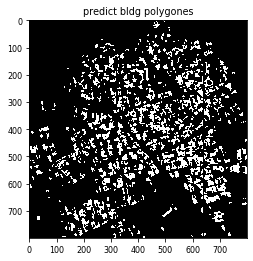

In [53]:
check_predict()

## Improvemnt

- Use large sizes of Image i.e.-1600
- Use hyperperameter tuning for U-Net.
- To improve, run the same U-Net model for several classes individually (change the output to only include one class). I used additional single models for buildings, structures, tracks and trees, the other predictions performed better from the 10 class model.

Thanks to visoft, n01z3, Sergey Mushinskiy, Konstantin Lopuhin for the great scripts and discussions.